In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import time
import pandas as pd
from IPython.display import clear_output

In [2]:
moon = pd.read_csv('C:\\Users\\went1\\Desktop\\ml_practice\\moon.txt', header=None, sep=',')
circle = pd.read_csv('C:\\Users\\went1\\Desktop\\ml_practice\\circle.txt', header=None, sep=',')

moon_x0 = moon[0]
moon_x1 = moon[1]

circle_x0 = circle[0]
circle_x1 = circle[1]

moon = np.array(moon)
circle = np.array(circle)

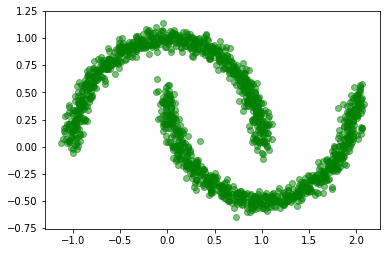

In [3]:
plt.scatter(moon_x0, moon_x1, marker='o', c='g',alpha=0.5)

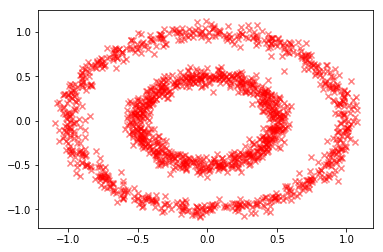

In [4]:
plt.scatter(circle_x0, circle_x1, marker='x', c='r', alpha=0.5)

In [92]:
class k_means:
    def __init__(self, data=[], k=2, method='normal', gamma=100, initial='random'):
        if len(data) == 0:
            print('Error. you need to give your data for clustering. Fuck you!')
            return
        
        self.method = method
        self.data = data
        self.features = data
        self.n = len(data)
        self.k = k
        self.gamma = gamma
                    
        if self.method == 'kernel':
            self.r = np.zeros([self.n, self.k])
            self.r[np.arange(self.n), np.random.randint(0, self.k, self.n)] = 1
            self.features = self._generateGramMatrix(self.data) + 1e-50
            return
        
        elif self.method == 'spectral':
            similiratiyMatrix = self._generateGramMatrix(self.data)
            self.features = self._buildNewFeatures(similiratiyMatrix)
        
        if initial == 'random':
            self._randomInitialize()
        
        elif initial == 'forgy':
            self._forgyInitialize()
        
        elif initial == 'kpp':
            self._kppInitialize()
    
    def _randomInitialize(self):
        self.r = np.zeros([self.n, self.k])
        self.r[np.arange(self.n), np.random.randint(0, self.k, self.n)] = 1
        up = self.r.T.dot(self.features)
        down = np.sum(self.r, axis=0)
        self.u = up / (down[:, None] + 1e-300)
    
    def _forgyInitialize(self):
        self.r = np.zeros([self.n, self.k])
        self.u = self.features[np.random.randint(0, self.n, self.k)]
    
    def _kppInitialize(self):
        self.r = np.zeros([self.n, self.k])
        self.u = self.features[np.random.randint(0, self.n, 1)]
        while len(self.u) < self.k:
            dist = np.empty([len(self.u), self.n])
            for i in range(len(self.u)):
                dist[i] =  np.linalg.norm(self.features - self.u[i], axis=1)
            distMin = dist[np.argmin(dist, axis=0), np.arange(self.n)]
            idx = np.argmax(distMin)
            print(len(self.u))
            self.u = np.append(self.u, self.features[idx])
            
           
    def _buildNewFeatures(self, W):
        D = np.diag(np.sum(W, axis=1))
        laplacianMatrix = D - W
        eiganValue, eiganVector = np.linalg.eig(laplacianMatrix)
        sortedIndex = np.argsort(eiganValue)
        sortedVector = eiganVector[:, sortedIndex]
        return sortedVector[:, :self.k]
        
    
    def _generateGramMatrix(self, data):
        data_norm = np.sum(data ** 2, axis = 1)
        return np.exp(-self.gamma * (data_norm[:,None] + data_norm[None,:] - 2 * data.dot(data.T)))
    
    def _distanceMatrix(self, alpha):
        if self.method == 'normal' or self.method == 'spectral':
            dist = np.empty([self.k, self.n])
            for i in range(self.k):
                dist[i] =  np.linalg.norm(self.features - self.u[i], axis=1)
            return dist
        
        elif self.method == 'kernel':
            self.phi_x = np.diag(self.features) ## need to be used on M-step.
            self.C = np.sum(alpha, axis=1) ## need to be used on M-step.
            
            phi_x_stack = np.empty([self.k, self.n])
            phi_x_stack[np.arange(self.k)] = self.phi_x
            
            F = 2 * alpha.dot(self.features.T) / self.C[:, None]
            G = np.zeros(self.k)
            for i in range(self.k):
                alpha_i = alpha[i]
                G[i] = np.sum(np.multiply(alpha_i[:, None].dot(alpha_i[None, :]), self.features)) / (self.C[i] ** 2)
            
            return phi_x_stack - F + G[:, None]
            
            
    def clustering(self, show=False, t = 1):
        colors = cm.rainbow(np.linspace(0, 1, self.k))
        r = self.r
        r_prev = r + 2
        iteration = 1
        while not np.array_equal(r, r_prev):
            r_prev = r
            ##E-step train parameter r[n][k]
            dist = self._distanceMatrix(r.T)
            distMinIdx = np.argmin(dist, axis=0)
            r = np.zeros([self.n, self.k])
            r[np.arange(self.n), distMinIdx] = 1
            ##E-step finish
            
            ##M-step train parameter u[n][2]
            if self.method == 'normal' or self.method == 'spectral':
                up = r.T.dot(self.features)
                down = np.sum(r, axis=0)
                u_new = up / (down[:, None] + 1e-300)
                self.u = u_new
            ##M-step finish

            if show:
                clear_output(wait=True)
                clusters = np.empty([0, 2])
                for i in range(self.k):
                    if self.method == 'normal':
                        print('Center of cluster ', i, ':', u_new[i])
                        plt.scatter(u_new[i][0], u_new[i][1], s=200, color=colors[i], marker='x')
                        
                    r_ni = r[:, i]
                    clusters_i = self.data[np.where(r_ni == 1)]
                    
                        
                    clusters = np.append(clusters, clusters_i, axis=0)
                    plt.subplot(1,2,1, aspect='equal', adjustable='box-forced')
                    plt.scatter(clusters_i[:, 0], clusters_i[:, 1], color=colors[i])
                plt.subplot(1,2,2, aspect='equal', adjustable='box-forced')
                plt.tight_layout()
                plt.imshow(self._generateGramMatrix(clusters), cmap='gray')
                plt.pause(0.0001)
                time.sleep(t)
                iteration += 1
        print('Total iteration:', iteration)
                

Center of cluster  0 : [-0.64954678  0.27947998]
Center of cluster  1 : [-0.44485452 -0.53274936]
Center of cluster  2 : [0.07621847 0.69394019]
Center of cluster  3 : [ 0.3854547  -0.58775537]
Center of cluster  4 : [0.68740715 0.16962105]


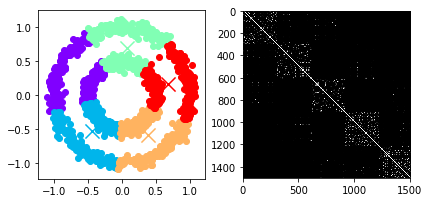

Total iteration: 13


In [29]:
normal = k_means(circle, method='normal', k=5, initial='random')
normal.clustering(show = True, t=0.001)

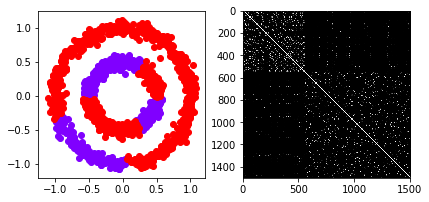

Total iteration: 19


In [95]:
kernel = k_means(circle, method='kernel', k=2, gamma=50)
kernel.clustering(show = True, t=0.1)

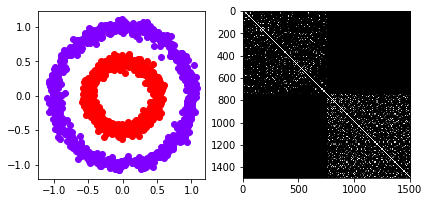

Total iteration: 3


In [82]:
spectral = k_means(circle, method='spectral', k=2, gamma=30, initial='random')
spectral.clustering(show = True, t=0.1)